# Fast Neural Style Transfer

In [1]:
from collections import namedtuple
import time 

import matplotlib.pyplot as plt
import numpy as np
import torch
# For getting VGG model
import torchvision.models.vgg as vgg
import torch.utils.model_zoo as model_zoo
# Image transformation pipeline
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.optim import Adam
from torch.autograd import Variable
from PIL import Image
from tqdm import tqdm_notebook

from transformer_net import TransformerNet
from utils import gram_matrix, recover_image, tensor_normalizer

%matplotlib inline

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
SEED = 1080
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    kwargs = {'num_workers': 4, 'pin_memory': True}
else:
    torch.set_default_tensor_type('torch.FloatTensor')
    kwargs = {}

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 4
DATASET = "coco/"
transform = transforms.Compose([transforms.Scale(IMAGE_SIZE),
                                transforms.CenterCrop(IMAGE_SIZE),
                                transforms.ToTensor(),
                                tensor_normalizer()])
# http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder
train_dataset = datasets.ImageFolder(DATASET, transform)
# http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

In [5]:
LossOutput = namedtuple("LossOutput", ["relu1_2", "relu2_2", "relu3_3", "relu4_3"])

# https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/3
class LossNetwork(torch.nn.Module):
    def __init__(self, vgg_model):
        super(LossNetwork, self).__init__()
        self.vgg_layers = vgg_model.features
        self.layer_name_mapping = {
            '3': "relu1_2",
            '8': "relu2_2",
            '15': "relu3_3",
            '22': "relu4_3"
        }
    
    def forward(self, x):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output[self.layer_name_mapping[name]] = x
        return LossOutput(**output)

In [6]:
vgg_model = vgg.vgg16(pretrained=True)
if torch.cuda.is_available():
    vgg_model.cuda()
loss_network = LossNetwork(vgg_model)
loss_network.eval()
del vgg_model

In [7]:
STYLE_IMAGE = "style_images/picasso.jpg"
style_img = Image.open(STYLE_IMAGE).convert('RGB')
style_img_tensor = transforms.Compose([
    transforms.ToTensor(),
    tensor_normalizer()]
)(style_img).unsqueeze(0)
# assert np.sum(style_img - recover_image(style_img_tensor.numpy())[0].astype(np.uint8)) < 3 * style_img_tensor.size()[2] * style_img_tensor.size()[3]
if torch.cuda.is_available():
    style_img_tensor = style_img_tensor.cuda()

Sanity check:

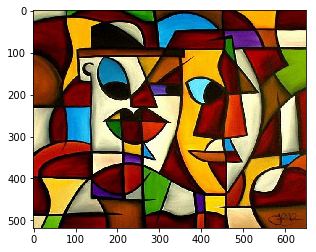

In [8]:
plt.imshow(recover_image(style_img_tensor.cpu().numpy())[0])

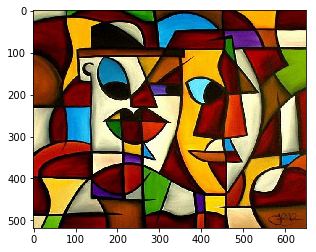

In [9]:
plt.imshow(recover_image(style_img_tensor.cpu().numpy())[0])

Precalculate gram matrices of the style image:

In [10]:
# http://pytorch.org/docs/master/notes/autograd.html#volatile
style_loss_features = loss_network(Variable(style_img_tensor, volatile=True))
gram_style = [Variable(gram_matrix(y).data, requires_grad=False) for y in style_loss_features]

In [11]:
style_loss_features._fields

('relu1_2', 'relu2_2', 'relu3_3', 'relu4_3')

In [12]:
np.mean(gram_style[3].data.cpu().numpy())

0.00033448191

In [13]:
np.mean(style_loss_features[3].data.cpu().numpy())

0.37621668

In [14]:
gram_style[0].numel()

4096

## Train the Transformer / Image Generator
Utility function to save debug images during training:

In [15]:
def save_debug_image(tensor_orig, tensor_transformed, filename):
    assert tensor_orig.size() == tensor_transformed.size()
    result = Image.fromarray(recover_image(tensor_transformed.cpu().numpy())[0])
    orig = Image.fromarray(recover_image(tensor_orig.cpu().numpy())[0])
    new_im = Image.new('RGB', (result.size[0] * 2 + 5, result.size[1]))
    new_im.paste(orig, (0,0))
    new_im.paste(result, (result.size[0] + 5,0))
    new_im.save(filename)

In [16]:
%mkdir -p debug

In [19]:
transformer = TransformerNet()
mse_loss = torch.nn.MSELoss()
# l1_loss = torch.nn.L1Loss()
if torch.cuda.is_available():
    transformer.cuda()

In [20]:
CONTENT_WEIGHT = 1
STYLE_WEIGHT = 1e5
LOG_INTERVAL = 200
REGULARIZATION = 1e-7

LR = 1e-3
optimizer = Adam(transformer.parameters(), LR)
transformer.train()
for epoch in range(2):
    agg_content_loss = 0.
    agg_style_loss = 0.
    agg_reg_loss = 0.
    count = 0
    for batch_id, (x, _) in tqdm_notebook(enumerate(train_loader), total=len(train_loader)):
        n_batch = len(x)
        count += n_batch
        optimizer.zero_grad()
        x = Variable(x)
        if torch.cuda.is_available():
            x = x.cuda()

        y = transformer(x)
        xc = Variable(x.data, volatile=True)

        features_y = loss_network(y)
        features_xc = loss_network(xc)

        f_xc_c = Variable(features_xc[1].data, requires_grad=False)

        content_loss = CONTENT_WEIGHT * mse_loss(features_y[1], f_xc_c)

        reg_loss = REGULARIZATION * (
            torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + 
            torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

        style_loss = 0.
        for m in range(len(features_y)):
            gram_s = gram_style[m]
            gram_y = gram_matrix(features_y[m])
            style_loss += STYLE_WEIGHT * mse_loss(gram_y, gram_s.expand_as(gram_y))

        total_loss = content_loss + style_loss + reg_loss
        total_loss.backward()
        optimizer.step()

        agg_content_loss += content_loss.data[0]
        agg_style_loss += style_loss.data[0]
        agg_reg_loss += reg_loss.data[0]

        if (batch_id + 1) % LOG_INTERVAL == 0:
            mesg = "{} [{}/{}] content: {:.6f}  style: {:.6f}  reg: {:.6f}  total: {:.6f}".format(
                        time.ctime(), count, len(train_dataset),
                        agg_content_loss / LOG_INTERVAL,
                        agg_style_loss / LOG_INTERVAL,
                        agg_reg_loss / LOG_INTERVAL,
                        (agg_content_loss + agg_style_loss + agg_reg_loss) / LOG_INTERVAL
                    )
            print(mesg)
            agg_content_loss = 0
            agg_style_loss = 0
            agg_reg_loss = 0
            transformer.eval()
            y = transformer(x)
            save_debug_image(x.data, y.data, "debug/{}_{}.png".format(epoch, count))
            transformer.train()


Sun Jul 30 10:24:24 2017 [800/82783] content: 7.999529  style: 24.931466  reg: 0.012636  total: 32.943631
Sun Jul 30 10:25:41 2017 [1600/82783] content: 8.451461  style: 7.808346  reg: 0.018677  total: 16.278484
Sun Jul 30 10:26:57 2017 [2400/82783] content: 8.096414  style: 5.505329  reg: 0.019482  total: 13.621225
Sun Jul 30 10:28:14 2017 [3200/82783] content: 7.644331  style: 4.611785  reg: 0.019897  total: 12.276013
Sun Jul 30 10:29:30 2017 [4000/82783] content: 7.421354  style: 4.228715  reg: 0.020327  total: 11.670396
Sun Jul 30 10:30:46 2017 [4800/82783] content: 7.204688  style: 3.905168  reg: 0.020600  total: 11.130455
Sun Jul 30 10:32:03 2017 [5600/82783] content: 6.991016  style: 3.781194  reg: 0.020920  total: 10.793130
Sun Jul 30 10:33:19 2017 [6400/82783] content: 6.849055  style: 3.560102  reg: 0.021310  total: 10.430467
Sun Jul 30 10:34:36 2017 [7200/82783] content: 6.655953  style: 3.529316  reg: 0.021583  total: 10.206851
Sun Jul 30 10:35:52 2017 [8000/82783] content

Sun Jul 30 12:03:59 2017 [63200/82783] content: 4.771870  style: 2.362108  reg: 0.028580  total: 7.162558
Sun Jul 30 12:05:16 2017 [64000/82783] content: 4.790397  style: 2.385826  reg: 0.028570  total: 7.204794
Sun Jul 30 12:06:32 2017 [64800/82783] content: 4.797771  style: 2.384635  reg: 0.028648  total: 7.211054
Sun Jul 30 12:07:49 2017 [65600/82783] content: 4.783288  style: 2.380335  reg: 0.028636  total: 7.192259
Sun Jul 30 12:09:06 2017 [66400/82783] content: 4.788761  style: 2.351798  reg: 0.028791  total: 7.169350
Sun Jul 30 12:10:23 2017 [67200/82783] content: 4.771074  style: 2.367260  reg: 0.028814  total: 7.167148
Sun Jul 30 12:11:40 2017 [68000/82783] content: 4.742648  style: 2.344417  reg: 0.028826  total: 7.115891
Sun Jul 30 12:12:56 2017 [68800/82783] content: 4.732495  style: 2.362614  reg: 0.028868  total: 7.123977
Sun Jul 30 12:14:13 2017 [69600/82783] content: 4.752332  style: 2.354943  reg: 0.028829  total: 7.136104
Sun Jul 30 12:15:29 2017 [70400/82783] content

Sun Jul 30 12:36:28 2017 [800/82783] content: 4.709271  style: 2.316700  reg: 0.029649  total: 7.055620
Sun Jul 30 12:37:44 2017 [1600/82783] content: 4.722560  style: 2.297936  reg: 0.029659  total: 7.050155
Sun Jul 30 12:39:01 2017 [2400/82783] content: 4.707896  style: 2.307248  reg: 0.029682  total: 7.044826
Sun Jul 30 12:40:17 2017 [3200/82783] content: 4.665572  style: 2.288175  reg: 0.029712  total: 6.983459
Sun Jul 30 12:41:34 2017 [4000/82783] content: 4.645368  style: 2.266602  reg: 0.029734  total: 6.941704
Sun Jul 30 12:42:50 2017 [4800/82783] content: 4.680799  style: 2.351559  reg: 0.029876  total: 7.062235
Sun Jul 30 12:44:07 2017 [5600/82783] content: 4.710224  style: 2.336476  reg: 0.030157  total: 7.076857
Sun Jul 30 12:45:23 2017 [6400/82783] content: 4.715261  style: 2.303933  reg: 0.030160  total: 7.049354
Sun Jul 30 12:46:39 2017 [7200/82783] content: 4.652289  style: 2.266943  reg: 0.029961  total: 6.949192
Sun Jul 30 12:47:56 2017 [8000/82783] content: 4.655703 

Sun Jul 30 14:15:58 2017 [63200/82783] content: 4.506164  style: 2.186558  reg: 0.032200  total: 6.724923
Sun Jul 30 14:17:15 2017 [64000/82783] content: 4.530503  style: 2.186286  reg: 0.032364  total: 6.749153
Sun Jul 30 14:18:31 2017 [64800/82783] content: 4.530192  style: 2.186961  reg: 0.032408  total: 6.749561
Sun Jul 30 14:19:48 2017 [65600/82783] content: 4.526804  style: 2.192362  reg: 0.032428  total: 6.751594
Sun Jul 30 14:21:05 2017 [66400/82783] content: 4.580293  style: 2.165258  reg: 0.032467  total: 6.778019
Sun Jul 30 14:22:21 2017 [67200/82783] content: 4.513045  style: 2.181810  reg: 0.032470  total: 6.727325
Sun Jul 30 14:23:38 2017 [68000/82783] content: 4.528408  style: 2.194693  reg: 0.032383  total: 6.755485
Sun Jul 30 14:24:54 2017 [68800/82783] content: 4.550455  style: 2.197151  reg: 0.032409  total: 6.780015
Sun Jul 30 14:26:11 2017 [69600/82783] content: 4.565878  style: 2.178107  reg: 0.032430  total: 6.776416
Sun Jul 30 14:27:28 2017 [70400/82783] content

In [21]:
import glob
fnames = glob.glob(DATASET + r"/*/*")
len(fnames)

82783

In [23]:
transformer = transformer.eval()

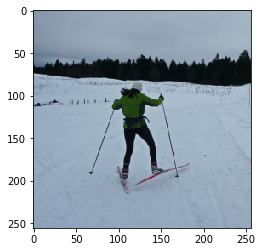

In [24]:
img = Image.open(fnames[40]).convert('RGB')
transform = transforms.Compose([transforms.Scale(IMAGE_SIZE),
                                transforms.CenterCrop(IMAGE_SIZE),
                                transforms.ToTensor(),
                                tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_tensor.cpu().numpy())[0])

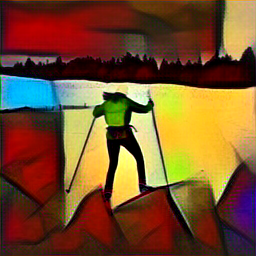

In [25]:
Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])

In [26]:
save_model_path = "model_udnie.pth"
torch.save(transformer.state_dict(), save_model_path)

In [27]:
transformer.load_state_dict(torch.load(save_model_path))

torch.Size([1, 3, 1080, 1080])


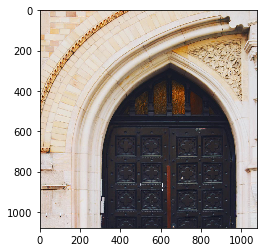

In [28]:
img = Image.open("content_images/amber.jpg").convert('RGB')
transform = transforms.Compose([transforms.ToTensor(),
                                tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
print(img_tensor.size())
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_tensor.cpu().numpy())[0])

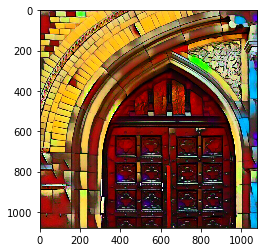

In [29]:
plt.imshow(recover_image(img_output.data.cpu().numpy())[0])

In [30]:
output_img = Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])
output_img.save("amber.png")